### import packages

In [1]:
import re

import icecream as ic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from matplotlib.lines import Line2D

from utill import (
    CycleFinder,
    DataFrameValidator,
    InfusionMapper,
)

# allow long prints of dataframes
pd.set_option("display.max_rows", 500)
%matplotlib inline

### Load data

In [2]:
# Re-loading the datasets
df_all = pd.read_csv(
    "data/df_all_filtered.csv",
    parse_dates=["diagdate", "toxeventdate"],
)

# Convert the 'diagdate' column to datetime format
df_all["diagdate"] = pd.to_datetime(df_all["diagdate"], format="%Y-%m-%d")

# Load the data
df_blood = pd.read_csv(
    "data/df_blood_filtered.csv",
    parse_dates=["sample_time", "most_recent_infusion_date", "next_infusion", "diagdate", "first_infusion_date"],
)

# # Convert the 'sample_time' column to datetime format
# df_blood["sample_time"] = pd.to_datetime(
#     df_blood["sample_time"], format="%Y-%m-%d %H:%M:%S"
# )
# # drop the column sex
# df_blood = df_blood.drop(columns=["sex"])

df_mtx = pd.read_csv(
    "data/df_mtx_filtered.csv",
    parse_dates=["mtx_inf_datetime"],
)

df_temp = pd.read_csv(
    "data/df_temp_filtered.csv",
    parse_dates=["sample_time", "diagdate"],
)

# # read parquet file
# df_bp = pd.read_parquet("blood_samples/blodtryk_df_40.parquet")

In [3]:
# remove patients from df_temp that are not in df_blood
df_temp = df_temp[df_temp.nopho_nr.isin(df_blood.nopho_nr)]
# # remove patients from df_temp that are not in df_blood
# df_bp = df_bp[df_bp.nopho_nr.isin(df_blood.nopho_nr)]

In [4]:
# print the number of nopho_nr in each dataset
print(f"Number of patients in df_all: {len(df_all.nopho_nr.unique())}")
print(f"Number of patients in df_blood: {len(df_blood.nopho_nr.unique())}")
print(f"Number of patients in df_mtx: {len(df_mtx.nopho_nr.unique())}")
print(f"Number of patients in df_temp: {len(df_temp.nopho_nr.unique())}")


Number of patients in df_all: 182
Number of patients in df_blood: 182
Number of patients in df_mtx: 182
Number of patients in df_temp: 66


### Add Infusion period information to Temp and BP dataframe, and concat temperature with blood dataframe 

In [5]:
# infusion_mapper = InfusionMapper(df_mtx, df_temp)
# df_temp = infusion_mapper.map_infno_to_samples()

In [6]:

df_blood['sample_time'] = pd.to_datetime(df_blood['sample_time'],  format='%Y-%m-%d %H:%M:%S')

# For columns that only require date without specific time
date_columns = ['diagdate', 'next_infusion', 'most_recent_infusion_date', 'first_infusion_date']
for column in date_columns:
    df_blood[column] = pd.to_datetime(df_blood[column], errors='coerce', format='%Y-%m-%d')

df_blood.dtypes



nopho_nr                              int64
component                            object
sample_time                  datetime64[ns]
reply_num                           float64
reply_unit                           object
diagdate                     datetime64[ns]
sample_date                          object
first_infusion_date          datetime64[ns]
infno                               float64
days_since_first_infusion           float64
next_infusion                datetime64[ns]
days_to_next_infusion               float64
most_recent_infusion_date    datetime64[ns]
days_since_last_inf                 float64
group                                object
dtype: object

In [7]:
df_blood.isnull().sum()

nopho_nr                          0
component                         0
sample_time                       0
reply_num                         0
reply_unit                        0
diagdate                          0
sample_date                       0
first_infusion_date               0
infno                             0
days_since_first_infusion    106827
next_infusion                327492
days_to_next_infusion        220665
most_recent_infusion_date    106827
days_since_last_inf          106827
group                             0
dtype: int64

In [8]:
# Convert 'sample_date' to datetime format and handle NaT/NaN values appropriately
df_blood['sample_date'] = pd.to_datetime(df_blood['sample_date']).dt.date

# Check for NaT/NaN values after conversion
nan_sample_dates = df_blood['sample_date'].isna().sum()
print(f"Number of NaT/NaN values in 'sample_date' after conversion: {nan_sample_dates}")




Number of NaT/NaN values in 'sample_date' after conversion: 0


In [9]:
df_blood.head()

,nopho_nr,component,sample_time,reply_num,reply_unit,diagdate,sample_date,first_infusion_date,infno,days_since_first_infusion,next_infusion,days_to_next_infusion,most_recent_infusion_date,days_since_last_inf,group
0,2008108,Monocytes;B,2008-07-02 08:30:00,0.23,× 10<sup>9</sup>/L,2008-07-01,2008-07-02,2008-08-07,0.0,NaN,NaT,36.0,NaT,NaN,not_missing
1,2008108,Albumin;P,2008-07-02 08:30:00,35.30,g/L,2008-07-01,2008-07-02,2008-08-07,0.0,NaN,NaT,36.0,NaT,NaN,not_missing
2,2008108,Lactate dehydrogenase [LDH],2008-07-02 08:30:00,228.00,U/L,2008-07-01,2008-07-02,2008-08-07,0.0,NaN,NaT,36.0,NaT,NaN,not_missing
3,2008108,C-reactive protein,2008-07-02 08:30:00,5.00,mg/L,2008-07-01,2008-07-02,2008-08-07,0.0,NaN,NaT,36.0,NaT,NaN,not_missing
4,2008108,Hemoglobin;B,2008-07-02 08:30:00,5.40,mmol/L,2008-07-01,2008-07-02,2008-08-07,0.0,NaN,NaT,36.0,NaT,NaN,not_missing


### Add age_at_sample, sex and transer and transth to df_blood

In [10]:
crp_diagdate_path = "/Users/jespervang/Projects/MTX/MTX data 2023/src/data/Nopho2008_crp_2023.csv"
crp_diagdate = pd.read_csv(
        crp_diagdate_path, parse_dates=["diagdate"], dayfirst=True
    )

def add_age_at_sample(df_cpr, df):
    df_cpr["nopho_nr"] = df_cpr["nopho_nr"].astype("int64")
    # Replace non-numeric 'birthdate' values with '000000', then convert to integer, then to string and pad with zeros
    df_cpr['birthdate'] = pd.to_numeric(df_cpr['birthdate'], errors='coerce').fillna(0).astype(int).astype(str).str.zfill(6)
    df_cpr['nopho_nr'] = df_cpr['nopho_nr'].astype(str)
    df['nopho_nr'] = df['nopho_nr'].astype(str)
    
    # Create full birthdate by combining day and month from 'birthdate' with the year from 'birthyear'
    full_birthdate = pd.to_datetime(df_cpr['birthyear'].astype(str) + df_cpr['birthdate'].str[2:4] + df_cpr['birthdate'].str[:2],
                                    format='%Y%m%d', errors='coerce')

    # Map 'full_birthdate' from df_cpr to df based on 'nopho_nr'
    df['full_birthdate'] = df['nopho_nr'].map(pd.Series(full_birthdate.values, index=df_cpr['nopho_nr']))

    # Calculate age at infno in years
    df['age_at_sample'] = (df['sample_time'] - df['full_birthdate']).dt.days // 365.25  # Account for leap years
    null_age_nopho_nrs = df[df['age_at_sample'].isnull()]['nopho_nr'].unique()
    print(null_age_nopho_nrs)
    print(df_cpr['nopho_nr'].isin(null_age_nopho_nrs).any())

    # Clean up: Drop the temporary 'full_birthdate' column
    df.drop('full_birthdate', axis=1, inplace=True)
    df["nopho_nr"] = df["nopho_nr"].astype("int64")

    return df
# Example usage, assuming you have 'df_cpr' and 'df_mtx' DataFrames prepared with the necessary columns
df_blood = add_age_at_sample(crp_diagdate, df_blood)
print(df_blood[df_blood['age_at_sample'].isnull()]['nopho_nr'].unique())



[]
False
[]


In [11]:
def add_sex(df_mtx, df) -> pd.DataFrame:
    sex_dict = df_mtx.set_index("nopho_nr")["sex"].to_dict()
    df["sex"] = df["nopho_nr"].map(sex_dict)

    return df


# Example usage:
df_blood = add_sex(df_mtx, df_blood)

In [12]:
def map_mtx_to_blood(df_blood, df_mtx):
    # Merge the required columns from df_mtx to df_blood based on 'nopho_nr' and 'infno'
    df_blood = df_blood.merge(df_mtx[['nopho_nr', 'infno', 'transer', 'transth']], on=['nopho_nr', 'infno'], how='left')
    
    # Replace 0 with NaN, 1 with 0, and 2 with 1 in the 'transer' and 'transth' columns
    df_blood['transer'] = df_blood['transer'].replace({0: None, 1: 0, 2: 1})
    df_blood['transth'] = df_blood['transth'].replace({0: None, 1: 0, 2: 1})
    
    # Check if any rows with missing were mapped and replaced
    if df_blood['transer'].isnull().any() or df_blood['transth'].isnull().any():
        print("Rows with missing values were mapped to df_blood and replaced with NaN.")
    
    return df_blood

# Assuming df_blood and df_mtx are already defined and loaded
df_blood = map_mtx_to_blood(df_blood, df_mtx)

Rows with missing values were mapped to df_blood and replaced with NaN.


In [13]:
df_blood.isna().sum()

nopho_nr                          0
component                         0
sample_time                       0
reply_num                         0
reply_unit                        0
diagdate                          0
sample_date                       0
first_infusion_date               0
infno                             0
days_since_first_infusion    106827
next_infusion                327492
days_to_next_infusion        220665
most_recent_infusion_date    106827
days_since_last_inf          106827
group                             0
age_at_sample                     0
sex                               0
transer                      109702
transth                      110049
dtype: int64

### Rename the columns

In [14]:
# rename cycles_since_start to cycle and days_since_cycle_started to cycle_day
df_blood = df_blood.rename(
    columns={
        "days_since_last_inf": "infno_day",
        "sample_time": "ds",
        "reply_num": "sample_value",
        "most_recent_infusion_date": "cycle_start_date",
    }
)

In [15]:
# shape of the datasets
print("Shape of df_all: ", df_all.shape)
print("Shape of df_blood: ", df_blood.shape)
print("Shape of df_mtx: ", df_mtx.shape)
print("Shape of df_temp: ", df_temp.shape)

Shape of df_all:  (182, 489)
Shape of df_blood:  (640033, 19)
Shape of df_mtx:  (1456, 125)
Shape of df_temp:  (5566, 6)


In [16]:
df_blood.dtypes

nopho_nr                              int64
component                            object
ds                           datetime64[ns]
sample_value                        float64
reply_unit                           object
diagdate                     datetime64[ns]
sample_date                          object
first_infusion_date          datetime64[ns]
infno                               float64
days_since_first_infusion           float64
next_infusion                datetime64[ns]
days_to_next_infusion               float64
cycle_start_date             datetime64[ns]
infno_day                           float64
group                                object
age_at_sample                       float64
sex                                   int64
transer                             float64
transth                             float64
dtype: object

### calculate_weight_change_between_cycles

In [17]:
def calculate_weight_change_between_cycles(df, df_mtx):
    # Ensure df_mtx is sorted by patient and cycle
    df_mtx_sorted = df_mtx.sort_values(by=['nopho_nr', 'infno'])
    
    # Calculate weight change between cycles
    df_mtx_sorted['weight_change_between_cycles'] = df_mtx_sorted.groupby('nopho_nr')['weight'].diff().fillna(0)
    
    # Merge the weight change information back into df based on nopho_nr and cycle
    # Assuming df has a column that corresponds to the cycle number that can be aligned with 'infno' from df_mtx
    df = df.merge(df_mtx_sorted[['nopho_nr', 'infno', 'weight_change_between_cycles']], 
                          left_on=['nopho_nr', 'infno'], right_on=['nopho_nr', 'infno'], 
                          how='left')
    
    # Handle any NaN values that may arise from cycles in df not present in df_mtx
    df['weight_change_between_cycles'] = df['weight_change_between_cycles'].fillna(0)
    
    return df

# Assuming df and df_mtx are already defined and loaded
df_blood = calculate_weight_change_between_cycles(df_blood, df_mtx)

### clean_components names

In [18]:
def clean_components(df):
    # Get the unique components in df_blood
    components_list = df["component"].unique().tolist()

    # Create a dictionary where the keys are the original component names and the values are the modified component names
    component_dict = {}
    for component in components_list:
        # Replace invalid characters with underscores
        valid_name = re.sub(r'\W|^(?=\d)', '_', component)
        # Replace multiple underscores with a single underscore
        valid_name = re.sub(r'__+', '_', valid_name)
        # Remove leading and trailing underscores
        valid_name = valid_name.strip('_')
        component_dict[component] = valid_name

    # Replace the values in the 'component' column of df_blood according to component_dict
    df["component"] = df["component"].map(component_dict)

    return df

df_blood = clean_components(df_blood)

In [19]:
def calculate_and_print_average_min_days_between_cycles(df):
    # Ensure 'cycle_start_date' is a datetime
    df['cycle_start_date'] = pd.to_datetime(df['cycle_start_date'])
    
    # Sort by patient and cycle start date to ensure correct order
    df = df.sort_values(by=['nopho_nr', 'infno'])
    
    # Drop duplicates to ensure one row per cycle per patient
    df = df.drop_duplicates(subset=['nopho_nr', 'infno'], keep='first')
    
    # Calculate the difference in days to the next cycle for each patient
    df['next_cycle_start_date'] = df['next_infusion']

    # Remove NaN values that result from shifting in the last cycle of each patient
    valid_differences = df.dropna(subset=['days_to_next_infusion'])
    
    # Calculate the overall average and minimum days between cycles across all patients
    overall_average_days = valid_differences['days_to_next_infusion'].mean()
    overall_min_days = valid_differences['days_to_next_infusion'].min()
    overall_max_days = valid_differences['days_to_next_infusion'].max()
    

    # Print the overall average and minimum days between cycles
    print(f"Overall average days between cycles across all patients: {overall_average_days:.2f} days")
    print(f"Overall minimum days between cycles across all patients: {overall_min_days} days")
    print(f"Overall maximum days between cycles across all patients: {overall_max_days} days")

    # Calculate and print the average and minimum days to the next cycle by cycle number for more detailed insight
    cycle_differences = valid_differences.groupby('infno')['days_to_next_infusion'].agg(['mean', 'min', 'max']).reset_index()
    cycle_differences.rename(columns={'mean': 'average_days_to_next_cycle', 'min': 'minimum_days_to_next_cycle', 'max': 'maximum_days_to_next_cycle'}, inplace=True)
    print("\nAverage and minimum days to next cycle by cycle number:")
    print(cycle_differences)

    # Find records leading to negative days to the next cycle
    negative_days = df[df['days_to_next_infusion'] < 0]
    print(negative_days[['nopho_nr', 'infno', 'cycle_start_date', 'next_cycle_start_date', 'days_to_next_infusion']])

    return cycle_differences


### remove before first cycle, remove infusion 9, remove patients with extreme deviation from infusion timing

In [20]:
df_blood.isna().sum()

nopho_nr                             0
component                            0
ds                                   0
sample_value                         0
reply_unit                           0
diagdate                             0
sample_date                          0
first_infusion_date                  0
infno                                0
days_since_first_infusion       106827
next_infusion                   327492
days_to_next_infusion           220665
cycle_start_date                106827
infno_day                       106827
group                                0
age_at_sample                        0
sex                                  0
transer                         109702
transth                         110049
weight_change_between_cycles         0
dtype: int64

In [21]:
print(f"shape before removing cycle = 0: {df_blood.shape}")
# remove samples with cycle = 0
df_blood = df_blood[df_blood.infno != 0]
# remove rows with infno = 9 
df_blood = df_blood[df_blood.infno != 9.0]
print(f"shape after removing cycle = 0: {df_blood.shape}")

shape before removing cycle = 0: (640033, 20)
shape after removing cycle = 0: (533206, 20)


In [22]:
df_blood.isna().sum()

nopho_nr                             0
component                            0
ds                                   0
sample_value                         0
reply_unit                           0
diagdate                             0
sample_date                          0
first_infusion_date                  0
infno                                0
days_since_first_infusion            0
next_infusion                   220665
days_to_next_infusion           220665
cycle_start_date                     0
infno_day                            0
group                                0
age_at_sample                        0
sex                                  0
transer                           2875
transth                           3222
weight_change_between_cycles         0
dtype: int64

In [23]:
common_patients = (
    set(df_all["nopho_nr"])
    .intersection(set(df_blood["nopho_nr"]))
    .intersection(set(df_mtx["nopho_nr"]))
)
df_all = df_all[df_all["nopho_nr"].isin(common_patients)]
df_blood = df_blood[df_blood["nopho_nr"].isin(common_patients)]
df_mtx = df_mtx[df_mtx["nopho_nr"].isin(common_patients)]
# number of patients
print("Number of patients: ", len(common_patients))

Number of patients:  182


In [24]:
def apply_minimum_days_cutoff(df_blood, cycle_min_days):
    """
    Applies a cutoff to df_blood based on the minimum_days_to_next_cycle for each cycle,
    excluding records where cycle_day is greater than the minimum_days_to_next_cycle for their respective cycle.

    Parameters:
    df_blood (pd.DataFrame): The main DataFrame containing patient cycle information.
    cycle_min_days (pd.DataFrame): DataFrame containing the minimum_days_to_next_cycle for each cycle.

    Returns:
    pd.DataFrame: The modified df_blood DataFrame after applying the cutoff.
    """
    df_blood = df_blood.copy()
    # Ensure 'infno' is float for matching
    df_blood['infno'] = df_blood['infno'].astype(int)

    # Merge the minimum_days_to_next_cycle information into df_blood
    df_blood = df_blood.merge(cycle_min_days[['infno', 'minimum_days_to_next_cycle']], on='infno', how='left')

    # Apply the cutoff based on minimum_days_to_next_cycle for each cycle
    df_blood = df_blood[df_blood['infno_day'] <= df_blood['minimum_days_to_next_cycle']]

    # Print the shape and unique patient count
    print(f"Shape after applying cutoff based on minimum_days_to_next_cycle: {df_blood.shape}")
    print(f"Unique patients after applying cutoff: {df_blood['nopho_nr'].nunique()}")

    return df_blood

# Example usage
cycle_min_days = pd.DataFrame({
    'infno': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
    'minimum_days_to_next_cycle': [20.0, 20.0, 55.0, 41.0, 47.0, 49.0, 46.0, 47.0]
})

# Assuming df_blood is already defined and loaded
df_blood = apply_minimum_days_cutoff(df_blood, cycle_min_days)

Shape after applying cutoff based on minimum_days_to_next_cycle: (287070, 21)
Unique patients after applying cutoff: 182


In [25]:
# drop columns iupac_code, diagdate, group
df_blood = df_blood.drop(columns=["diagdate", "group"], errors="ignore")

In [26]:
patient_id = 2009138
patient_data = df_blood[df_blood['nopho_nr'] == patient_id]
patient_data


,nopho_nr,component,ds,sample_value,reply_unit,sample_date,first_infusion_date,infno,days_since_first_infusion,next_infusion,days_to_next_infusion,cycle_start_date,infno_day,age_at_sample,sex,transer,transth,weight_change_between_cycles,minimum_days_to_next_cycle
76999,2009138,Erythrocytes_mean_corpuscular_volume_MCV,2010-01-04 06:00:00,85.00,fL,2010-01-04,2010-01-04,1,0.0,2010-01-25,21.0,2010-01-04,0.0,1.0,2,0.0,0.0,0.0,20.0
77000,2009138,Thrombocytes_B,2010-01-04 06:00:00,205.00,× 10<sup>9</sup>/L,2010-01-04,2010-01-04,1,0.0,2010-01-25,21.0,2010-01-04,0.0,1.0,2,0.0,0.0,0.0,20.0
77001,2009138,C_reactive_protein,2010-01-04 06:00:00,35.00,mg/L,2010-01-04,2010-01-04,1,0.0,2010-01-25,21.0,2010-01-04,0.0,1.0,2,0.0,0.0,0.0,20.0
77002,2009138,Hemoglobin_B,2010-01-04 06:00:00,6.50,mmol/L,2010-01-04,2010-01-04,1,0.0,2010-01-25,21.0,2010-01-04,0.0,1.0,2,0.0,0.0,0.0,20.0
77003,2009138,Erythrocytes_B,2010-01-04 06:00:00,3.60,× 10<sup>12</sup>/L,2010-01-04,2010-01-04,1,0.0,2010-01-25,21.0,2010-01-04,0.0,1.0,2,0.0,0.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78469,2009138,Neutrophilocytes_B,2011-02-07 10:20:00,9.49,× 10<sup>9</sup>/L,2011-02-07,2010-01-04,8,399.0,NaT,NaN,2010-12-27,42.0,2.0,2,1.0,1.0,0.9,47.0
78470,2009138,Eosinophilocytes_B,2011-02-07 10:20:00,0.00,× 10<sup>9</sup>/L,2011-02-07,2010-01-04,8,399.0,NaT,NaN,2010-12-27,42.0,2.0,2,1.0,1.0,0.9,47.0
78471,2009138,Basophilocytes_P,2011-02-07 10:20:00,0.00,× 10<sup>9</sup>/L,2011-02-07,2010-01-04,8,399.0,NaT,NaN,2010-12-27,42.0,2.0,2,1.0,1.0,0.9,47.0
78472,2009138,Lymphocytes_B,2011-02-07 10:20:00,0.40,× 10<sup>9</sup>/L,2011-02-07,2010-01-04,8,399.0,NaT,NaN,2010-12-27,42.0,2.0,2,1.0,1.0,0.9,47.0


In [27]:
print(f"shape before removing na rows from subset=['infno', 'infno_day']: {df_blood.shape}")
# drop na rows from subset=['infno', 'infno_day']
df_blood = df_blood.dropna(subset=["infno", "infno_day"])
print(f"shape after removing na rows from subset=['infno', 'infno_day']: {df_blood.shape}")
# remove samples from before first_infusion_date
df_blood = df_blood[df_blood.ds >= df_blood.first_infusion_date]
print(f"shape after removing samples from before first_infusion_date: {df_blood.shape}")
print(df_blood.nopho_nr.nunique())


shape before removing na rows from subset=['infno', 'infno_day']: (287070, 19)
shape after removing na rows from subset=['infno', 'infno_day']: (287070, 19)
shape after removing samples from before first_infusion_date: (287070, 19)
182


In [28]:
# Calculate and print the average and minimum days between cycles
cycle_differences = calculate_and_print_average_min_days_between_cycles(df_blood)

Overall average days between cycles across all patients: 50.11 days
Overall minimum days between cycles across all patients: 18.0 days
Overall maximum days between cycles across all patients: 134.0 days

Average and minimum days to next cycle by cycle number:
   infno  average_days_to_next_cycle  minimum_days_to_next_cycle  \
0      1                   21.901099                        19.0   
1      2                   21.967033                        18.0   
2      3                   74.890110                        56.0   
3      4                   59.010989                        49.0   
4      5                   58.565934                        49.0   
5      6                   57.241758                        48.0   
6      7                   57.214286                        47.0   

   maximum_days_to_next_cycle  
0                        33.0  
1                        29.0  
2                       134.0  
3                        84.0  
4                        84.0  
5  

In [29]:
common_patients = (
    set(df_all["nopho_nr"])
    .intersection(set(df_blood["nopho_nr"]))
    .intersection(set(df_mtx["nopho_nr"]))
)
df_all = df_all[df_all["nopho_nr"].isin(common_patients)]
df_blood = df_blood[df_blood["nopho_nr"].isin(common_patients)]
df_mtx = df_mtx[df_mtx["nopho_nr"].isin(common_patients)]
# number of patients
print("Number of patients: ", len(common_patients))

Number of patients:  182


In [30]:
# which columns have missing values nan or nat
df_blood.isna().sum()

nopho_nr                            0
component                           0
ds                                  0
sample_value                        0
reply_unit                          0
sample_date                         0
first_infusion_date                 0
infno                               0
days_since_first_infusion           0
next_infusion                   27141
days_to_next_infusion           27141
cycle_start_date                    0
infno_day                           0
age_at_sample                       0
sex                                 0
transer                          1212
transth                          1471
weight_change_between_cycles        0
minimum_days_to_next_cycle          0
dtype: int64

In [31]:
df_blood.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287070 entries, 0 to 532159
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   nopho_nr                      287070 non-null  int64         
 1   component                     287070 non-null  object        
 2   ds                            287070 non-null  datetime64[ns]
 3   sample_value                  287070 non-null  float64       
 4   reply_unit                    287070 non-null  object        
 5   sample_date                   287070 non-null  object        
 6   first_infusion_date           287070 non-null  datetime64[ns]
 7   infno                         287070 non-null  int64         
 8   days_since_first_infusion     287070 non-null  float64       
 9   next_infusion                 259929 non-null  datetime64[ns]
 10  days_to_next_infusion         259929 non-null  float64       
 11  cycle_start_date  

### Plot for combined Methotrexate samples

In [32]:
def plot_methotrexate_levels(df_blood):
    df_blood = df_blood.copy()

    # Convert times to datetime and normalize reply_num to µmol/L
    df_blood["cycle_start_date"] = pd.to_datetime(df_blood["cycle_start_date"])
    df_blood["ds"] = pd.to_datetime(df_blood["ds"])
    df_methotrexate = df_blood[df_blood["component"] == "Methotrexate_P"].copy()
    df_methotrexate["sample_value"] /= 1000

    # Reset time_from_start for each patient and infusion
    df_methotrexate["time_from_start"] = (
        df_methotrexate["ds"] - df_methotrexate["cycle_start_date"]
    ).dt.total_seconds() / 3600

    # Define a maximum time from start, e.g., 400 hours
    max_hours_from_start = 400
    df_methotrexate = df_methotrexate[
        df_methotrexate["time_from_start"] <= max_hours_from_start
    ]

    # Define bin size and create bins up to the maximum observed time
    bin_size = 12  # Adjust bin size as needed
    bins = np.arange(0, max_hours_from_start + bin_size, bin_size)
    df_methotrexate["time_bin"] = pd.cut(df_methotrexate["time_from_start"], bins=bins)

    # Calculate mean and percentiles for each bin
    grouped = (
        df_methotrexate.groupby("time_bin")["sample_value"]
        .agg(
            mean="mean",
            percentile_5=lambda x: x.quantile(0.05),
            percentile_95=lambda x: x.quantile(0.95),
            count="count",
        )
        .reset_index()
    )

    # Apply a filter to exclude bins with a low sample count
    min_samples = 8
    grouped = grouped[grouped["count"] >= min_samples]

    # Convert time_bin to the midpoint of each interval for plotting
    grouped["time_bin_mid"] = grouped["time_bin"].apply(lambda x: x.mid)

    # Create scatter plot for individual patient's Methotrexate levels over time
    scatter_plot = go.Scatter(
        x=df_methotrexate["time_from_start"],
        y=df_methotrexate["sample_value"],
        mode="markers",
        name="Individual Data",
        marker=dict(
            color="rgba(0, 104, 201, 0.5)",
        ),
    )

    # Create traces for the mean and percentiles
    mean_trace = go.Scatter(
        x=grouped["time_bin_mid"],
        y=grouped["mean"],
        mode="lines",
        name="Mean",
        line=dict(width=2, color="rgba(254, 43, 42, 0.9)"),
    )

    percentile_5_trace = go.Scatter(
        x=grouped["time_bin_mid"],
        y=grouped["percentile_5"],
        mode="lines",
        line=dict(width=0),
        showlegend=False,
    )

    percentile_95_trace = go.Scatter(
        x=grouped["time_bin_mid"],
        y=grouped["percentile_95"],
        mode="lines",
        line=dict(width=0),
        fill="tonexty",
        fillcolor="rgba(131, 200, 255, 0.3)",
        name="5th and 95th Percentiles",
        showlegend=True,
    )

    # Define layout
    layout = go.Layout(
        title="Methotrexate levels over time with Mean and 5th & 95th Percentiles",
        plot_bgcolor="white",
        paper_bgcolor="white",
        width=1024,
        height=768,
        xaxis=dict(
            title="Time from start (hours)",
            type="linear",
            range=[0, 300],
            dtick=24,
            showline=True,
            linecolor="Black",
        ),
        yaxis=dict(
            title="Methotrexate level (µmol/L) - Log Scale",
            type="log",
            showline=True,
            linecolor="Black",
            gridcolor="rgb(206, 208, 214)",
            gridwidth=1,
        ),
    )

    # Create figure and add traces
    fig = go.Figure(layout=layout)

    fig.add_trace(percentile_5_trace)
    fig.add_trace(percentile_95_trace)
    fig.add_trace(scatter_plot)
    fig.add_trace(mean_trace)

    # Show the figure
    fig.show()


# plot_methotrexate_levels(df_blood)

### calculate_recovery_days_adjusted_multi_neutropenia_with_intervals

In [33]:
def extended_analyze_samples_per_patient(df, percent_close_threshold=5):
    """
    Analyzes the number of blood samples per patient for each component within the same day,
    including information about duplicate or nearly duplicate sample values based on a percentage threshold.
    Additionally, provides an overview per unique component, including total samples, total duplicates,
    and the mean close values for the components.
    
    Args:
    - df (pd.DataFrame): Input dataframe with columns 'nopho_nr' for patient number, 
                         'ds' for datetime of the sample, 'component' for the sample component,
                         and 'sample_value' for the value of the sample.
    - percent_close_threshold (float): Percentage threshold to determine if values are considered close to each other.
    
    Returns:
    - pd.DataFrame: Summary of samples per component per patient per day, including duplicate info.
    - pd.DataFrame: Overview of components with the most samples per patient in the same day.
    - pd.DataFrame: Overview per unique component, including total samples, total duplicates, and the mean close values.
    """
    # Ensure 'ds' is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Function to analyze each group for duplicates and close values
    def analyze_group(group):
        group = group.sort_values(by='sample_value')  # Sort by sample_value for diff calculation
        group['is_duplicate'] = group['sample_value'].duplicated(keep=False)
        # Calculate the percentage difference between consecutive samples
        group['percent_diff'] = group['sample_value'].diff().abs() / group['sample_value'].shift(1) * 100
        # Determine if the difference is less than the threshold
        group['is_close'] = group['percent_diff'] < percent_close_threshold
        return group
    
    df = df.groupby(['nopho_nr', df['ds'].dt.date, 'component'], as_index=False).apply(analyze_group)
    
    # Count samples per day including duplicates and close values
    samples_count = df.groupby(['nopho_nr', df['ds'].dt.date, 'component']).agg(
        samples_per_day=('sample_value', 'size'),
        duplicates=('is_duplicate', 'sum'),
        close_values=('is_close', 'sum')
    ).reset_index()
    
    # Find the maximum number of samples for each component per patient
    max_samples_per_component = samples_count.groupby(['nopho_nr', 'component'])['samples_per_day'].max().reset_index(name='max_samples_per_day')
    
    # Find components with the most samples per patient in the same day
    components_most_samples = max_samples_per_component.sort_values(by='max_samples_per_day', ascending=False)
    
    # Aggregate data at the component level for the overview
    component_overview = df.groupby('component').agg(
        total_samples=('sample_value', 'size'),
        total_duplicates=('is_duplicate', 'sum'),
        mean_close_values=('is_close', 'mean')
    ).reset_index()
    
    return samples_count, components_most_samples, component_overview

# Assuming df_blood is your DataFrame and it includes a 'sample_value' column
# Apply the function
# samples_count, components_most_samples, component_overview = extended_analyze_samples_per_patient(df_blood, percent_close_threshold=5)

# # Review the results
# print(samples_count.sort_values(by='samples_per_day', ascending=False).head())
# print(components_most_samples.head())
# print(component_overview.sort_values(by='total_samples', ascending=False).head())

In [34]:
from collections import defaultdict


def refine_samples_to_daily_means_with_report(df):
    """
    Refines the dataset to ensure that for each patient, for each component, on each day,
    there is only one sample value by removing exact duplicates and then aggregating the remaining
    samples by the mean for each day. Also reports the total number of duplicates removed.

    Args:
    - df (pd.DataFrame): Input dataframe with datetime timestamps, component information, and sample values.

    Returns:
    - pd.DataFrame: Refined dataframe with one sample per component per day per patient.
    - dict: Report on the number of duplicates removed and modifications made.
    """
    # Ensure 'ds' is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])

    # Initialize report dictionary
    report = defaultdict(int)

    # Count initial number of rows for duplicate calculation
    initial_row_count = len(df)

    # Convert 'ds' to date for daily aggregation
    df['date'] = df['ds'].dt.date
        # Remove exact duplicates (same patient, day, component, and sample value)
    df = df.drop_duplicates(subset=['nopho_nr', 'date', 'component', 'sample_value'])
        # Update report with the number of duplicates removed
    report['total_duplicates_removed'] = initial_row_count - len(df)

    # Aggregate by mean sample value for each patient, day, and component
    daily_mean_df = df.groupby(['nopho_nr', 'date', 'component'], as_index=False)['sample_value'].mean()

    # Update report with modifications made
    report['total_modifications'] = initial_row_count - len(daily_mean_df)

    return daily_mean_df, dict(report)

# Assuming df_blood is your DataFrame
# Apply the function to refine the dataset and get the report
# refined_df_blood, refinement_report = refine_samples_to_daily_means_with_report(df_blood)

# # Review the refined dataset and the report
# print(refined_df_blood.head())
# print(refinement_report)
# print(refined_df_blood.shape)

In [35]:
def calculate_recovery_days_adjusted_multi_neutropenia_with_intervals(df, neutrophil_threshold=0.5, recovery_confirmation_days=2, minimum_neutropenia_duration=3):
    df['ds'] = pd.to_datetime(df['ds'])
    df['cycle_start_date'] = pd.to_datetime(df['cycle_start_date'])
    df['recovery_day'] = None
    df['neutropenia_status'] = 'unknown'
    df['neutropenia_episodes'] = 0
    df['onset_day'] = None
    df['nadir'] = None  # Initialize, but will only update for the first episode

    for (nopho_nr, infno), group in df.groupby(['nopho_nr', 'infno']):
        neutrophil_data = group[group['component'] == 'Neutrophilocytes_B'].sort_values(by='ds')
        ongoing_neutropenia = False
        episode_count = 0
        cycle_start_date = group['cycle_start_date'].iloc[0]
        nadir_value = float('inf')  # Initialize to infinity
        first_episode_recorded = False
        
        for i, row in neutrophil_data.iterrows():
            if row['sample_value'] < neutrophil_threshold and not ongoing_neutropenia:
                onset_date = row['ds']
                ongoing_neutropenia = True
                episode_count += 1  # Increment at the start of an episode

                if not first_episode_recorded:  # Only for the first episode
                    onset_day = (onset_date - cycle_start_date).days
                    df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'onset_day'] = onset_day
                    nadir_value = row['sample_value']  # Set nadir for the first episode
                    first_episode_recorded = True
            
                    
            elif ongoing_neutropenia:
                if first_episode_recorded:  # Update nadir only for the first episode
                    if row['sample_value'] < nadir_value:
                        nadir_value = row['sample_value']
                        
                if row['sample_value'] >= neutrophil_threshold:
                    if onset_date is not None and (row['ds'] - onset_date).days >= minimum_neutropenia_duration:
                        recovery_period = neutrophil_data.loc[i:min(i+recovery_confirmation_days-1, neutrophil_data.index[-1])]
                        if all(recovery_period['sample_value'] >= neutrophil_threshold):
                            recovery_date = row['ds']
                            ongoing_neutropenia = False
                            if first_episode_recorded:  # Set recovery day for the first episode
                                recovery_day = (recovery_date - cycle_start_date).days
                                df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'recovery_day'] = recovery_day
                                df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'nadir'] = nadir_value
                                first_episode_recorded = False  # Ensure no further updates for nadir or recovery_day

        # After processing each group
        if episode_count > 0:
            df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'neutropenia_episodes'] = episode_count
            if ongoing_neutropenia:  # If the episode was ongoing and it was the first
                df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'neutropenia_status'] = 'ongoing'
            else:
                df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'neutropenia_status'] = 'resolved'
        else:
            df.loc[(df['nopho_nr'] == nopho_nr) & (df['infno'] == infno), 'neutropenia_status'] = 'no_neutropenia'
            
    return df


# Assuming df_blood is your DataFrame
# Apply the function to calculate recovery days and update the DataFrame
df_blood = calculate_recovery_days_adjusted_multi_neutropenia_with_intervals(df_blood, neutrophil_threshold=0.5, recovery_confirmation_days=3, minimum_neutropenia_duration=3)

In [36]:
# Adjusted calculation to include total and count along with median for recovery_day and onset_day per cycle
detailed_days_per_cycle = df_blood.groupby('infno').agg(
    median_recovery_day=('recovery_day', 'median'),
    avg_recovery_day=('recovery_day', 'mean'),
    total_recovery_days=('recovery_day', 'sum'),
    count_recovery_days=('recovery_day', 'count'),
    median_onset_day=('onset_day', 'median'),
    avg_onset_day=('onset_day', 'mean'),
    total_onset_days=('onset_day', 'sum'),
    count_onset_days=('onset_day', 'count')
).reset_index()

# Print the detailed results
print("Detailed Recovery and Onset Day per infno:")
print(detailed_days_per_cycle)


Detailed Recovery and Onset Day per infno:
   infno median_recovery_day avg_recovery_day total_recovery_days  \
0      1                11.0        12.373653              295025   
1      2                 7.0        10.480973              109893   
2      3                28.0        27.675066             1092833   
3      4                28.0        25.243073              460989   
4      5                28.0        28.666929              728914   
5      6                28.0        26.930077              454849   
6      7                26.0        25.695001              365460   
7      8                24.0        24.695862              285904   

   count_recovery_days median_onset_day avg_onset_day total_onset_days  \
0                23843             11.0     10.480573           343920   
1                10485             14.0      12.57535           218044   
2                39488             38.0     33.301348          1553408   
3                18262             18.0

### plot onset day

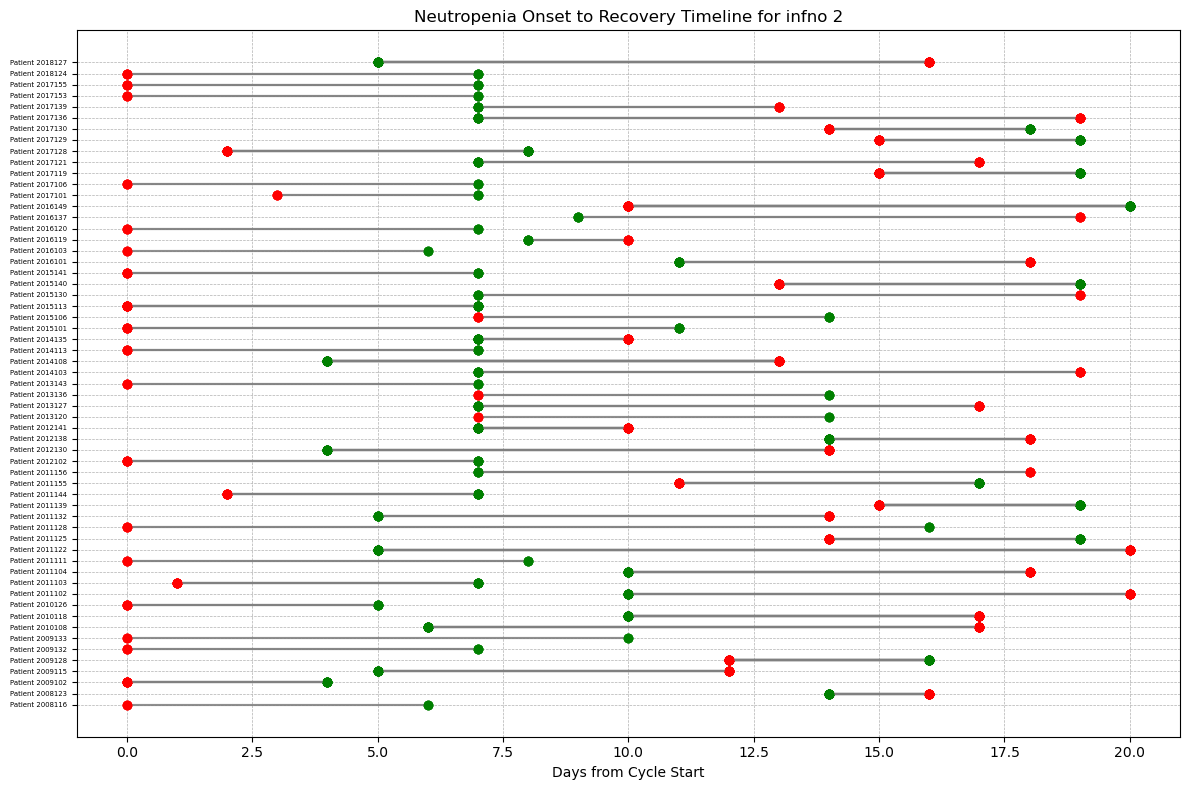

In [37]:
import matplotlib.pyplot as plt

def plot_onset_recovery_timeline(df, infno):
    # Filter the DataFrame for the specified cycle and component 'Neutrophilocytes_B'
    cycle_data = df[(df['infno'] == infno) & (df['component'] == 'Neutrophilocytes_B')][['nopho_nr', 'onset_day', 'recovery_day']].dropna()

    # Ensure onset_day and recovery_day are integers for consistent plotting
    cycle_data['onset_day'] = cycle_data['onset_day'].astype(int)
    cycle_data['recovery_day'] = cycle_data['recovery_day'].astype(int)

    # Sort by nopho_nr for consistent visualization
    cycle_data.sort_values(by='nopho_nr', inplace=True)

    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Get unique patient numbers and map them to y positions
    unique_patients = cycle_data['nopho_nr'].unique()
    patient_positions = {patient: i for i, patient in enumerate(unique_patients)}
    
    # Plot a line for each patient's neutropenia duration
    for _, row in cycle_data.iterrows():
        patient_position = patient_positions[row['nopho_nr']]
        # Plot a horizontal line for the duration of neutropenia
        plt.hlines(y=patient_position, xmin=row['onset_day'], xmax=row['recovery_day'], color='grey', alpha=0.5)
        # Plot red points for onset and green points for recovery
        plt.plot(row['onset_day'], patient_position, 'ro')  # red point for onset
        plt.plot(row['recovery_day'], patient_position, 'go')  # green point for recovery

    # Set y-ticks to match the patient positions
    plt.yticks(range(len(unique_patients)), labels=[f'Patient {nr}' for nr in unique_patients], fontsize=5)
    plt.xlabel('Days from Cycle Start')
    plt.title(f'Neutropenia Onset to Recovery Timeline for infno {infno}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Assuming df_blood is your DataFrame
# Plot the onset to recovery timeline for a specific cycle
plot_onset_recovery_timeline(df_blood, infno=2)

In [38]:
df_blood.head()

,nopho_nr,component,ds,sample_value,reply_unit,sample_date,first_infusion_date,infno,days_since_first_infusion,next_infusion,...,sex,transer,transth,weight_change_between_cycles,minimum_days_to_next_cycle,recovery_day,neutropenia_status,neutropenia_episodes,onset_day,nadir
0,2008108,Plasmocytes,2008-08-07 09:30:00,0.00,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
1,2008108,Monocytes_B,2008-08-07 09:30:00,0.12,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
2,2008108,Lymphocytes_B,2008-08-07 09:30:00,4.60,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
3,2008108,Basophilocytes_P,2008-08-07 09:30:00,0.03,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
4,2008108,Metamyelocytes_B,2008-08-07 09:30:00,0.00,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None


No onset and recovery day data found for patient 2012107 and infno 1.
No onset and recovery day data found for patient 2008116 and infno 1.


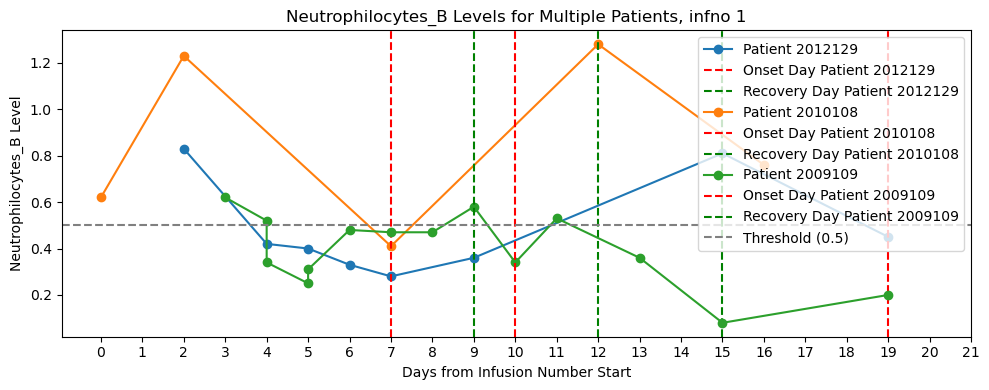

In [39]:
def plot_neutrophilocytes_b_levels(patients, infno=1): # Default to infno 1 if not specified, now accepts a list of patients
    plt.figure(figsize=(10, 4))
    
    for nopho_nr in patients:
        # Filter for the specific patient, infno, and component
        patient_data = df_blood[(df_blood['nopho_nr'] == nopho_nr) & 
                                (df_blood['infno'] == infno) & 
                                (df_blood['component'] == 'Neutrophilocytes_B')]

        # Check if patient_data is empty
        if patient_data.empty:
            print(f"No data found for patient {nopho_nr} and infno {infno}.")
            continue

        # Extract onset_day and recovery_day for the specific patient and infno
        onset_recovery_info = df_blood[(df_blood['nopho_nr'] == nopho_nr) & 
                                       (df_blood['infno'] == infno)][['onset_day', 'recovery_day']].dropna()

        # Check if onset_recovery_info is empty
        if onset_recovery_info.empty:
            print(f"No onset and recovery day data found for patient {nopho_nr} and infno {infno}.")
            continue
        else:
            onset_day = onset_recovery_info.iloc[0]['onset_day']
            recovery_day = onset_recovery_info.iloc[0]['recovery_day']

        # Plot Neutrophilocytes_B levels over time for each patient
        plt.plot(patient_data['infno_day'], patient_data['sample_value'], marker='o', linestyle='-', label=f'Patient {nopho_nr}')

        # Overlay onset_day and recovery_day
        if not pd.isnull(onset_day) and not pd.isnull(patient_data.iloc[0]['cycle_start_date']):
            plt.axvline(x=onset_day, color='red', linestyle='--', label=f'Onset Day Patient {nopho_nr}')
        if not pd.isnull(recovery_day) and not pd.isnull(patient_data.iloc[0]['cycle_start_date']):
            plt.axvline(x=recovery_day, color='green', linestyle='--', label=f'Recovery Day Patient {nopho_nr}')

    plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')

    plt.title(f'Neutrophilocytes_B Levels for Multiple Patients, infno {infno}')
    plt.xlabel('Days from Infusion Number Start')
    plt.ylabel('Neutrophilocytes_B Level')
    plt.legend()
    plt.xticks(range(22))  # Adjusted to have integers from 0 to 21 on the x-axis
    plt.tight_layout()
    plt.show()

# Example usage
plot_neutrophilocytes_b_levels([2012129, 2012107, 2010108, 2008116, 2009109], 1)


In [40]:
# give five random patients
patients = df_blood['nopho_nr'].sample(5).tolist()
print(patients)

[2013155, 2017104, 2011149, 2016117, 2013130]


In [41]:
df_blood.head()

,nopho_nr,component,ds,sample_value,reply_unit,sample_date,first_infusion_date,infno,days_since_first_infusion,next_infusion,...,sex,transer,transth,weight_change_between_cycles,minimum_days_to_next_cycle,recovery_day,neutropenia_status,neutropenia_episodes,onset_day,nadir
0,2008108,Plasmocytes,2008-08-07 09:30:00,0.00,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
1,2008108,Monocytes_B,2008-08-07 09:30:00,0.12,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
2,2008108,Lymphocytes_B,2008-08-07 09:30:00,4.60,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
3,2008108,Basophilocytes_P,2008-08-07 09:30:00,0.03,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None
4,2008108,Metamyelocytes_B,2008-08-07 09:30:00,0.00,× 10<sup>9</sup>/L,2008-08-07,2008-08-07,1,0.0,2008-08-28,...,1,0.0,1.0,0.0,20.0,None,no_neutropenia,0,None,None


In [42]:
# missing values
df_blood.isna().sum()

nopho_nr                             0
component                            0
ds                                   0
sample_value                         0
reply_unit                           0
sample_date                          0
first_infusion_date                  0
infno                                0
days_since_first_infusion            0
next_infusion                    27141
days_to_next_infusion            27141
cycle_start_date                     0
infno_day                            0
age_at_sample                        0
sex                                  0
transer                           1212
transth                           1471
weight_change_between_cycles         0
minimum_days_to_next_cycle           0
recovery_day                    126875
neutropenia_status                   0
neutropenia_episodes                 0
onset_day                        91224
nadir                           126875
dtype: int64

### select columns needed

In [43]:
columns_needed = ['ds','first_infusion_date', 'nopho_nr','sex', 'age_at_sample', 'weight_change_between_cycles', 'transer', 'transth', 'component', 'sample_value', 'reply_unit', 'days_since_first_infusion', 'infno', 'infno_day',]
new_df = df_blood[columns_needed].copy()



In [44]:
new_df.isna().sum()

ds                                 0
first_infusion_date                0
nopho_nr                           0
sex                                0
age_at_sample                      0
weight_change_between_cycles       0
transer                         1212
transth                         1471
component                          0
sample_value                       0
reply_unit                         0
days_since_first_infusion          0
infno                              0
infno_day                          0
dtype: int64

In [45]:
new_df.rename(
    columns={
        "nopho_nr": "unique_id",
        "weight_change_between_cycles": "weight_change_cycles",
        "sample_value": "value",
        "reply_unit": "unit",
    },
    inplace=True,
)

In [46]:
patients_with_nan = new_df[(new_df['transer'].isna()) | (new_df['transth'].isna())]['unique_id'].nunique()
print(f"Number of patients with NaN in 'transer' or 'transth': {patients_with_nan}")


Number of patients with NaN in 'transer' or 'transth': 9


In [47]:
print(new_df.shape)
print(new_df.dtypes)
print(new_df.columns)


(287070, 14)
ds                           datetime64[ns]
first_infusion_date          datetime64[ns]
unique_id                             int64
sex                                   int64
age_at_sample                       float64
weight_change_cycles                float64
transer                             float64
transth                             float64
component                            object
value                               float64
unit                                 object
days_since_first_infusion           float64
infno                                 int64
infno_day                           float64
dtype: object
Index(['ds', 'first_infusion_date', 'unique_id', 'sex', 'age_at_sample',
       'weight_change_cycles', 'transer', 'transth', 'component', 'value',
       'unit', 'days_since_first_infusion', 'infno', 'infno_day'],
      dtype='object')


In [48]:
new_df.head()

,ds,first_infusion_date,unique_id,sex,age_at_sample,weight_change_cycles,transer,transth,component,value,unit,days_since_first_infusion,infno,infno_day
0,2008-08-07 09:30:00,2008-08-07,2008108,1,3.0,0.0,0.0,1.0,Plasmocytes,0.00,× 10<sup>9</sup>/L,0.0,1,0.0
1,2008-08-07 09:30:00,2008-08-07,2008108,1,3.0,0.0,0.0,1.0,Monocytes_B,0.12,× 10<sup>9</sup>/L,0.0,1,0.0
2,2008-08-07 09:30:00,2008-08-07,2008108,1,3.0,0.0,0.0,1.0,Lymphocytes_B,4.60,× 10<sup>9</sup>/L,0.0,1,0.0
3,2008-08-07 09:30:00,2008-08-07,2008108,1,3.0,0.0,0.0,1.0,Basophilocytes_P,0.03,× 10<sup>9</sup>/L,0.0,1,0.0
4,2008-08-07 09:30:00,2008-08-07,2008108,1,3.0,0.0,0.0,1.0,Metamyelocytes_B,0.00,× 10<sup>9</sup>/L,0.0,1,0.0


In [49]:
neutrophilocytes_b_range = new_df[new_df['component'] == 'Neutrophilocytes_B']['value'].agg(['min', 'max'])
print(f"Range of Neutrophilocytes_B across all patients: {neutrophilocytes_b_range}")


Range of Neutrophilocytes_B across all patients: min     0.0
max    44.3
Name: value, dtype: float64


In [57]:
for infno in range(1, 9):
    infno_days = new_df[new_df['infno'] == infno]['infno_day']
    min_infno_day = infno_days.min()
    max_infno_day = infno_days.max()
    deviation_infno_day = infno_days.std()
    print(f"Infno {infno}: Min infno_day = {min_infno_day}, Max infno_day = {max_infno_day}, Deviation = {deviation_infno_day}")


Infno 1: Min infno_day = 0.0, Max infno_day = 20.0, Deviation = 5.912077609090513
Infno 2: Min infno_day = 0.0, Max infno_day = 20.0, Deviation = 6.091018249616364
Infno 3: Min infno_day = 0.0, Max infno_day = 55.0, Deviation = 17.308173650521482
Infno 4: Min infno_day = 0.0, Max infno_day = 41.0, Deviation = 12.347450091016364
Infno 5: Min infno_day = 0.0, Max infno_day = 47.0, Deviation = 14.540858925918087
Infno 6: Min infno_day = 0.0, Max infno_day = 49.0, Deviation = 14.40796029687032
Infno 7: Min infno_day = 0.0, Max infno_day = 46.0, Deviation = 13.662451246131967
Infno 8: Min infno_day = 0.0, Max infno_day = 47.0, Deviation = 14.654444080256765


In [50]:
# df_blood = df_blood[['nopho_nr', 'sex', 'age_at_sample', 'weight_change_between_cycles', 'component', 'sample_value', 'reply_unit', 'infno', 'infno_day', 'onset_day', 'nadir', 'recovery_day', 'neutropenia_status', 'neutropenia_episodes']]


### save to csv

In [51]:
#save the data
new_df.to_csv('data/df_blood_preprocessed.csv', index=False)

In [52]:
new_df.head(2000).to_csv('data/df_blood_preprocessed_first_2000.csv', index=False)
